In [1]:
#SCRIPT PRA ACESSAR DADOS DE PRECIPITAÇÃO TOTAL

Primeiramente vamos importar as bibliotecas necessárias para que o script consiga ser rodado. Neste script vamos utilizar as seguintes bibliotecas, com o site onde se pode obter informações sobre a mesma. xarray: https://docs.xarray.dev/en/stable/index.html matplotlib: https://matplotlib.org/stable/ numpy: https://numpy.org/ cartopy: https://scitools.org.uk/cartopy/docs/latest/ scipy: https://scipy.org/ ecmwf.opendata: https://confluence.ecmwf.int/display/WEBAPI/Access+MARS

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
from scipy.ndimage.filters import maximum_filter, minimum_filter
import scipy.ndimage as ndimage
from ecmwf.opendata import Client

In [2]:
# AQUI VAMOS DEFINIR UM MÉTODO PRA OBTER OS VALORES MÁXIMOS DE PRECIPITAÇÃO, PODE SER USADO EM QUALQUER VARIÁVEL

def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):

        txt2 = ax.annotate('\n' + str(int(data[mxy[i], mxx[i]])), xy=(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]]),
                           xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), 
                color=color, size=11, clip_on=True, annotation_clip=True, fontweight='bold', fontfamily='serif',
                           horizontalalignment='center', verticalalignment='top',
                transform=ccrs.PlateCarree())  

In [3]:
date=20231115   # Data da inicialização do modelo
time=0          # Hora da rodada do modelo
step=240        # Hora analisada, neste caso 180h, mas pode ser efetuado em até 240h

In [4]:
# O ACESSO AOS DADOS SERÁ FEITO PELA API DO ECMWF:

client = Client()
client.retrieve(
    date=date, 
    time=time,      
    step=step,     
    stream="oper",
    type="fc",
    levtype="sfc",
    param="tp",
    target="prec.grib2"  # Formato a ser salvo o arquivo
)

20231115000000-240h-oper-fc.grib2:   0%|          | 0.00/440k [00:00<?, ?B/s]

In [5]:
# COM O XARRAY SERÁ REALIZADO A LEITURA DO ARQUIVO

ds=xr.open_dataset("prec.grib2", engine="cfgrib")

In [6]:
# EXTRAINDO OS DADOS DO ARQUIVO, NO CASO A LONGITUDE, LATITUDE, E A VARIÁVEL (PRECIPITAÇÃO TOTAL)

prec=ds['tp']*1000
lon=ds['longitude']
lat=ds['latitude']

In [7]:
# CÓDIGO USADO PARA SUAVIZAR OS CONTORNOS DA PRECIPITAÇÃO

precP=ndimage.gaussian_filter(prec,sigma=.7,order=0)

In [8]:
# A função numpy.meshgrid é usada para criar uma grade retangular a partir de duas matrizes unidimensionais que representam 
# a indexação cartesiana ou a indexação matricial

lon,lat=np.meshgrid(prec.longitude,prec.latitude)

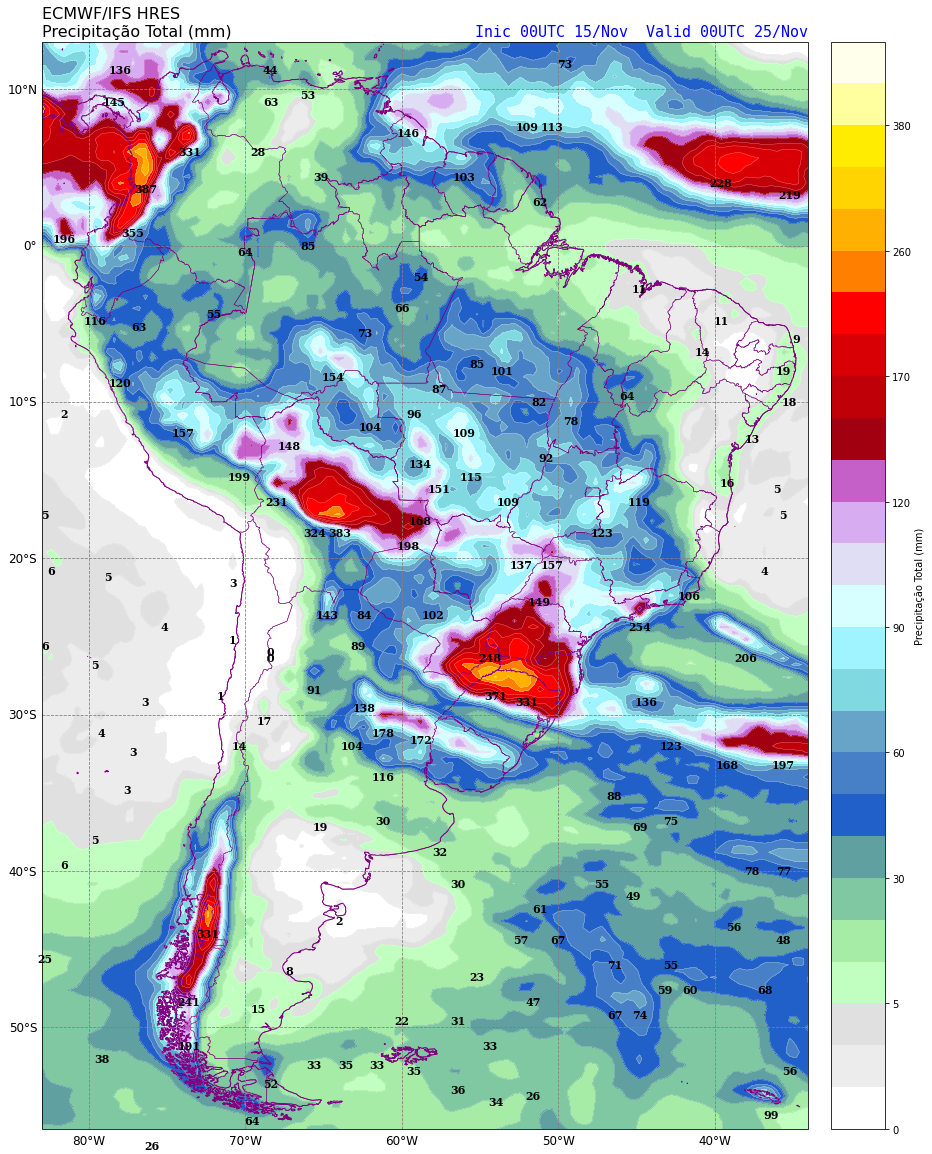

In [9]:
# Criando um objeto de figura para receber o mapa
fig = plt.figure(figsize=(20, 20))

# Criando um eixo com a projeção escolhida
ax = plt.axes(projection=ccrs.PlateCarree())

# Adicionando os limites do oceano
ax.coastlines(resolution="10m",color='purple')

# Definindo a extensão da área a ser plotada
ax.set_extent([-83,-34,12,-54])

# Definindo a paleta personalizada de cores
cores=['#ffffff','#ececec','#e0e0e0','#c0ffc0','#a6eca6','#80c8a2','#60a0a0','#2060c8','#4880c8','#68a4c8','#80d8e0','#a0f4ff',
       '#d8ffff','#e0def4','#d8acf0','#c460c8','#a00010','#c00008','#d80004','#ff0000','#ff8000','#ffb000','#ffd400','#ffec00',
       '#ffffa0','#ffffec']

# Definindo os valores mínimos e máximos correspondente a paleta 
levels=[0,1,3,5,10,20,30,40,50,60,70,80,90,100,110,120,130,150,170,200,230,260,300,340,380,430,500]

# Plotando os dado para a área especificada anteriormente 
im=ax.contourf(lon,lat,precP,levels=levels,
               colors=cores,
               transform=ccrs.PlateCarree())

im1=ax.contour(lon,lat,precP,levels=levels,
               linewidths=0.2,
              colors='white',
              transform=ccrs.PlateCarree())

# Plotando os valores máximo 
plot_maxmin_points(lon,lat,prec,'max',8,symbol='máx',
                   color='k',
                   transform=ccrs.PlateCarree())

# Adicionando os limites estaduais e mascarando outras áreas
## OBS: Em 'shpreader.Reader' você deve definir o caminho do mapa do seu computador, portanto o endereço será diferente do ##
##      apresentado abaixo.                                                                                                ##
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/10/ne_10m_admin_0_countries.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='purple',facecolor='none',linestyle='-',linewidth=.5)
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/BR/BR_UF_2022.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='purple',facecolor='none',linestyle='-',linewidth=.5)

# Adicionando linhas de grade
g1=ax.gridlines(crs=ccrs.PlateCarree(),linestyle='--',color='gray',draw_labels=True)

# Removendo os labels do topo e da direita
g1.right_labels=False
g1.top_labels=False

# Formatando os labels como latitude e longitude
g1.yformatter=LATITUDE_FORMATTER
g1.xformatter=LONGITUDE_FORMATTER
g1.ylabel_style={'size':12,'color':'black'}
g1.xlabel_style={'size':12,'color':'black'}

# Definindo a colorbar
cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.049,orientation='vertical')
cbar.set_label(label='Precipitação Total (mm)',size=10)

# Inserindo título
plt.title('ECMWF/IFS HRES\nPrecipitação Total (mm)',fontsize=16,loc='left')
plt.title(ds.time.dt.strftime('Inic %HUTC %d/%b  ').item()+ds.valid_time.dt.strftime('Valid %HUTC %d/%b').item(),
          fontsize=15,loc='right',color='blue',fontweight='normal',fontfamily='monospace')

# Salvando a imagem
plt.savefig(ds.valid_time.dt.strftime('%HUTC_%d_%b').item()+'.jpeg',dpi=300,bbox_inches='tight')